In [1]:
import geopandas as gpd
import contextily as cx
import pandas as pd
%matplotlib inline
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import scipy as sp
import xarray as xr
from sklearn.linear_model import LinearRegression

In [2]:
datapath = '/Users/zhu/Dropbox/Database/Hera/comb/'
filename = 'wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t2_4km.csv'

In [3]:
voc_species = pd.DataFrame(columns = ['col'])

spc = ['CH$_4$', 'ch4','Gas_CH4_Insitu_S_AVMR','CH4_ppb','CH4_NOAA_Picarro_ppb_1min']
voc_species.loc[0,'col'] = spc

spc = ['Methanol', 'moh','x33_0334892273_CH5O_','CH3OH_NOAAPTR_ppbv','CH3OH_NOAAPTR_ppbv_all']
voc_species.loc[1,'col'] = spc

spc = ['Ethanol', 'eoh', 'x47_0491409302_C2H7O_', 'C2H5OH_NOAAPTR_ppbv', 'C2H5OH_NOAAPTR_ppbv_all']
voc_species.loc[2,'col'] = spc

spc = ['Acetaldehyde', 'acd','x45_0334892273_C2H5O_','CH3CHO_NOAAPTR_ppbv','CH3CHO_NOAAPTR_ppbv_all']
voc_species.loc[3,'col'] = spc

spc = ['Acetone', 'act','x59_0491409302_C3H7O_','AcetonePropanal_NOAAPTR_ppbv','AcetonePropanal_NOAAPTR_ppbv_all']
voc_species.loc[4,'col'] = spc

spc = ['Isoprene','iso','x69_0698776245_C5H9_','isoprene_NOAAPTR_ppbv','isoprene_NOAAPTR_ppbv_all']
voc_species.loc[5,'col'] = spc

spc = ['MACR+MVK','C4H6O_model','x71_0491409302_C4H7O_','MVKMAC_NOAAPTR_ppbv','MVKMAC_NOAAPTR_ppbv_all']
voc_species.loc[6,'col'] = spc

spc = ['Monoterpene','Monoterpenes_model','x137_1324768066_C10H17_','monoterpenes_NOAAPTR_ppbv','monoterpenes_NOAAPTR_ppbv_all']
voc_species.loc[7,'col'] = spc

spc = ['Benzene','ben','x79_0542297363_C6H7_','Benzene_NOAAPTR_ppbv','Benzene_NOAAPTR_ppbv_all']
voc_species.loc[8,'col'] = spc

spc = ['Toluene','tol','x93_0698776245_C7H9_','toluene_NOAAPTR_ppbv','toluene_NOAAPTR_ppbv_all']
voc_species.loc[9,'col'] = spc

spc = ['Benzaldehyde','bald','x107_0491409302_C7H7O_','benzaldehyde_NOAAPTR_ppbv','benzaldehyde_NOAAPTR_ppbv_all']
voc_species.loc[10,'col'] = spc

spc = ['Xylene','xyl','x107_0855255127_C8H11_','C8Aromatics_NOAAPTR_ppbv','C8Aromatics_NOAAPTR_ppbv_all']
voc_species.loc[11,'col'] = spc

spc = ['D5-siloxane', 'd5silx', 'x371_1012268066_C10H31O5Si5_', 'D5siloxane_NOAAPTR_ppbv', 'D5siloxane_NOAAPTR_ppbv_all']
voc_species.loc[12,'col'] = spc

spc = ['PCBTF', 'pcbtf','x181_0026397705_C7H4ClF3H_','PCBTF_NOAAPTR_ppbv','PCBTF_NOAAPTR_ppbv_all']
voc_species.loc[13,'col'] = spc


In [5]:
wrf_comb_species = pd.DataFrame(columns = ['col'])
wrf_comb_species.loc['C4H6O_model','col'] = ['macr','mvk']
wrf_comb_species.loc['Monoterpenes_model','col'] = ['api','lim','eclp']

pair_wrf = []
for i in range(voc_species.shape[0]):
    if '_model' in voc_species.loc[i,'col'][1]:
        pair_wrf = pair_wrf + wrf_comb_species.loc[voc_species.loc[i,'col'][1],'col']
    else:
        pair_wrf.append(voc_species.loc[i,'col'][1])
        
pair_obs = []
for i in range(voc_species.shape[0]):
    pair_obs.append(voc_species.loc[i,'col'][2:])
pair_obs = np.array(pair_obs)

pair_model = []
for i in range(voc_species.shape[0]):
    pair_model.append(voc_species.loc[i,'col'][0])


In [6]:
def read_modeled_vocr(df_wrf_supp, this_df):
    cols = df_wrf_supp.columns
    vocr_cols = [col for col in cols if '_' not in col and col != 'co']
    df_wrf_vocr = df_wrf_supp.loc[:, vocr_cols]
    
    this_df.loc[:,'tot_vocr_model'] = df_wrf_vocr.sum(axis=1)
    this_df.loc[:,'calibrated_vocr_model'] = df_wrf_vocr.loc[:,pair_wrf].sum(axis=1)
    this_df.loc[:,'calibrated_ratio'] = this_df.loc[:,'calibrated_vocr_model']/this_df.loc[:,'tot_vocr_model']
    df_wrf_vocr = df_wrf_vocr.loc[:,pair_wrf] 
    return this_df

def read_vocr(df_wrf_supp, this_df, i_name):
    model_vocr=[col+'_model_vocr' for col in pair_model]
    obs_vocr=[col+'_obs_vocr' for col in pair_model]
    
    df_vocr = pd.DataFrame(columns=model_vocr+obs_vocr)
    
    for i_voc, this_voc in enumerate(pair_model):
        this_obs = voc_species.loc[i_voc,'col'][i_name+2]
        this_wrfs = []
        this_wrf = voc_species.loc[i_voc,'col'][1]
        if '_model' in this_wrf:
            this_wrfs = wrf_comb_species.loc[voc_species.loc[i_voc,'col'][1],'col']
        else:
            this_wrfs.append(this_wrf)
        this_wrf_conc_sum = this_df.loc[:,this_wrfs].sum(axis=1)
        for i_wrf, this_wrf in enumerate(this_wrfs):
            this_conc = this_df.loc[:,this_wrf]
            this_conc_ratio = this_df.loc[:,this_wrf]/this_wrf_conc_sum
            this_koh = df_wrf_supp.loc[:,this_wrf+'_rate']
            this_obs_conc = this_df.loc[:,this_obs]
            
            if i_wrf == 0:
                df_vocr.loc[:,this_voc+'_model_vocr'] = this_conc *1e-9 *2e19 * this_koh 
                df_vocr.loc[:,this_voc+'_obs_vocr'] = this_obs_conc *1e-9 *2e19 * this_koh * this_conc_ratio
            else:
                df_vocr.loc[:,this_voc+'_model_vocr'] = df_vocr.loc[:,this_voc+'_model_vocr']+this_conc *1e-9 *2e19 * this_koh 
                df_vocr.loc[:,this_voc+'_obs_vocr'] = df_vocr.loc[:,this_voc+'_obs_vocr'] + this_obs_conc *1e-9 *2e19 * this_koh * this_conc_ratio
                
            #print(this_voc)
            #print(np.nanmedian(df_vocr.loc[:,this_voc+'_obs_vocr'] ))
    return df_vocr
    
df_wrfs = []
df_vocrs = []
names = ['airborne_','mobile_','ground_']
for i_name, name in enumerate(names):

    #read obs+model
    this_df = pd.read_csv(datapath + name + filename)

    # read vocr file
    df_wrf_supp = pd.read_csv(datapath + name + filename[:-4]+'-vocr.csv')

    #convert the unit of CH4 in airborne and ground
    if name in ['airborne_','ground_']:
        this_df.loc[:,'ch4'] = this_df.loc[:,'ch4']*1e3
        df_wrf_supp.loc[:,'ch4'] = df_wrf_supp.loc[:,'ch4']*1e3
    if name in ['ground_']:
        this_df.loc[:,'CH4_NOAA_Picarro_ppb_1min'] = this_df.loc[:,'CH4_NOAA_Picarro_ppb_1min']
    if name in ['airborne_']:
        this_df.loc[:,'Gas_CH4_Insitu_S_AVMR'] = this_df.loc[:,'Gas_CH4_Insitu_S_AVMR']*1e3
    if name in ['mobile_']:
        this_df.loc[:,'mek'] = this_df.loc[:,'mek']/1e3
        df_wrf_supp.loc[:,'mek'] = df_wrf_supp.loc[:,'mek']/1e3
        
    #read model VOCr
    this_df= read_modeled_vocr(df_wrf_supp, this_df)
    
    # read measured + modeled VOCr
    df_vocr = read_vocr(df_wrf_supp, this_df, i_name)
    model_vocr=[col+'_model_vocr' for col in pair_model]
    obs_vocr=[col+'_obs_vocr' for col in pair_model]

    this_df.loc[:,'calibrated_vocr_obs'] = df_vocr.loc[:,obs_vocr].sum(axis=1)
    this_df.loc[:,'calibrated_vocr_model'] = df_vocr.loc[:,model_vocr].sum(axis=1)
    df_wrfs.append(this_df)
    df_vocrs.append(df_vocr)
    

In [7]:
temp_bin = pd.read_csv('/Users/zhu/Dropbox/Database/Hera/AQS/temp_bin.csv')
print(temp_bin.columns)

Index(['Unnamed: 0', 'time_local', 'date', 'TEMP', 'temp_index',
       'temp_bin_index'],
      dtype='object')


In [8]:
#airborne
df_wrfs[0] = df_wrfs[0].drop(columns=['temp_bin_index']).merge(temp_bin,left_on='date_local',right_on='date')
#mobile
df_wrfs[1] = df_wrfs[1].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')
#ground
df_wrfs[2] = df_wrfs[2].drop(columns=['temp_bin_index']).merge(temp_bin,on='date')

In [9]:
df_wrfs[2]['NOx_LIF'] = df_wrfs[2]['NO_LIF'] + df_wrfs[2]['NO2_LIF']
df_wrfs[2]['CH4_NOAA_Picarro_ppb_1min'] = df_wrfs[2]['CH4_NOAA_Picarro_ppb_1min']/1e3
df_wrfs[2]['CO_NOAA_Picarro_ppb_1min'] = df_wrfs[2]['CO_NOAA_Picarro_ppb_1min']/1e3
df_wrfs[2]['NOx_CIT_AQS'] = df_wrfs[2]['NO_CIT_AQS'] + df_wrfs[2]['NO2_CIT_AQS']
#correct octanal
df_wrfs[0]['x129_1273956299_C8H17O_'] = df_wrfs[0]['x129_1273956299_C8H17O_']*6.75

In [11]:
def calc_stat(pair_model, pair_wrf, airborne_obs, mobile_obs, ground_obs):
    print(pair_model)
    nmeb = (np.nanmedian(df_wrfs[0][pair_wrf])-np.nanmedian(df_wrfs[0][airborne_obs]))/np.nanmedian(df_wrfs[0][airborne_obs])
    corr = (df_wrfs[0].loc[:,[airborne_obs,pair_wrf]].corr().loc[airborne_obs,pair_wrf])**2
    print(nmeb,corr)
    nmeb = (np.nanmedian(df_wrfs[1][pair_wrf])-np.nanmedian(df_wrfs[1][mobile_obs]))/np.nanmedian(df_wrfs[1][mobile_obs])
    corr = (df_wrfs[1].loc[:,[mobile_obs,pair_wrf]].corr().loc[mobile_obs,pair_wrf])**2
    print(nmeb,corr)
    nmeb = (np.nanmedian(df_wrfs[2][pair_wrf])-np.nanmedian(df_wrfs[2][ground_obs]))/np.nanmedian(df_wrfs[2][ground_obs])
    corr = (df_wrfs[2].loc[:,[ground_obs,pair_wrf]].corr().loc[ground_obs,pair_wrf])**2
    print(nmeb,corr)

for i in range(voc_species.shape[0]):
    calc_stat(voc_species.loc[i,'col'][0], voc_species.loc[i,'col'][1], voc_species.loc[i,'col'][2], voc_species.loc[i,'col'][3], voc_species.loc[i,'col'][4])
              

CH$_4$
-0.039553644391225384 0.4779790924664252
-0.04467344538765899 0.0032449408766514276
976.5367172025873 0.2742185069708999
Methanol
0.009788816386633651 0.6723747613051465
0.03560655028856289 0.08161881832544648
0.40665645859381977 0.028830704337610633
Ethanol
-0.7532702310016236 0.5207835893220869
-0.415393249668301 0.0755858176276049
-0.31501132889283323 0.28205198545534105
Acetaldehyde
0.47427557102897316 0.28606306299469375
-0.48193818418613393 0.02917848551211383
-0.2076342002582585 0.5613691659463567
Acetone
-0.3298668890418946 0.6522638050516786
-0.1413882057146875 0.022715363537881828
-0.0045955407028450196 0.19614555890873742
Isoprene
-0.4577954835119717 0.2508330256907034
-0.008832702108255687 0.177628458139343
-0.22991206700151612 0.5834443047064757
MACR+MVK
-0.4782258269794513 0.6072076030683087
0.11131736778556608 0.5193823586642637
-0.25243227783614 0.5505604941697222
Monoterpene
-0.8951076500619739 0.19676423888600184
-0.30566769086199513 2.749777606241137e-05
-0.52

In [12]:
def concatenate_df(pair_model, pair_wrf, airborne_obs, mobile_obs, ground_obs):
    conc_df = pd.DataFrame()

    #combine airborne
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,airborne_obs].values
    this_df.loc[:,'temp_obs'] = df_wrfs[0].loc[:,'temp_obs'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values
    this_df.loc[:,'data_index'] = 'RECAP Obs'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])


    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,pair_wrf].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[0].loc[:,'temperature_k_x'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values
    this_df.loc[:,'data_index'] = 'RECAP wrf'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])
    
    if (pair_wrf not in ['NOx_model','co']):
        #combine mobile

        this_df = pd.DataFrame()

        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,mobile_obs].values
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_x'].values
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'data_index'] = 'SUNVEX Obs'
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])


        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,pair_wrf].values
        this_df.loc[:,'data_index'] = 'SUNVEX wrf'
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_x'].values
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
        

    #combine ground
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,ground_obs].values
    this_df.loc[:,'data_index'] = 'SUNVEX Obs'
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
   
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_wrf].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    this_df.loc[:,'data_index'] = 'SUNVEX wrf'
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
    
    conc_df.dropna(subset=pair_model)
    return conc_df


In [13]:
#from left to right 
#pair_model#airborne_obs, airborne_wrf, mobile_obs, mobile_wrf, ground_obs, ground_wrf
species = pd.DataFrame(columns = ['col'])

#'NOx_CIT_AQS'
spc = ['NO$_x$ \n (ppb)', 'NOx_model','NOx_obs','NOx_ppbv','NOx_NOAA_NOxCaRD_ppbv_all']
species.loc[0,'col'] = spc

spc = ['CO \n (ppm)', 'co','Gas_CO_Insitu_S_AVMR','CO_ppb','CO_NOAA_Picarro_ppb_1min']
species.loc[1,'col'] = spc

spc = ['D5-siloxane \n (ppb)', 'd5silx', 'x371_1012268066_C10H31O5Si5_', 'D5siloxane_NOAAPTR_ppbv', 'D5siloxane_NOAAPTR_ppbv_all']
species.loc[2,'col'] = spc

spc = ['PCBTF \n  (ppb)', 'pcbtf','x181_0026397705_C7H4ClF3H_','PCBTF_NOAAPTR_ppbv','PCBTF_NOAAPTR_ppbv_all']
species.loc[3,'col'] = spc

spc = ['Calibrated VOC$_r$ \n (s$^{-1}$)', 'calibrated_vocr_model','calibrated_vocr_obs','calibrated_vocr_obs','calibrated_vocr_obs']
species.loc[4,'col'] = spc


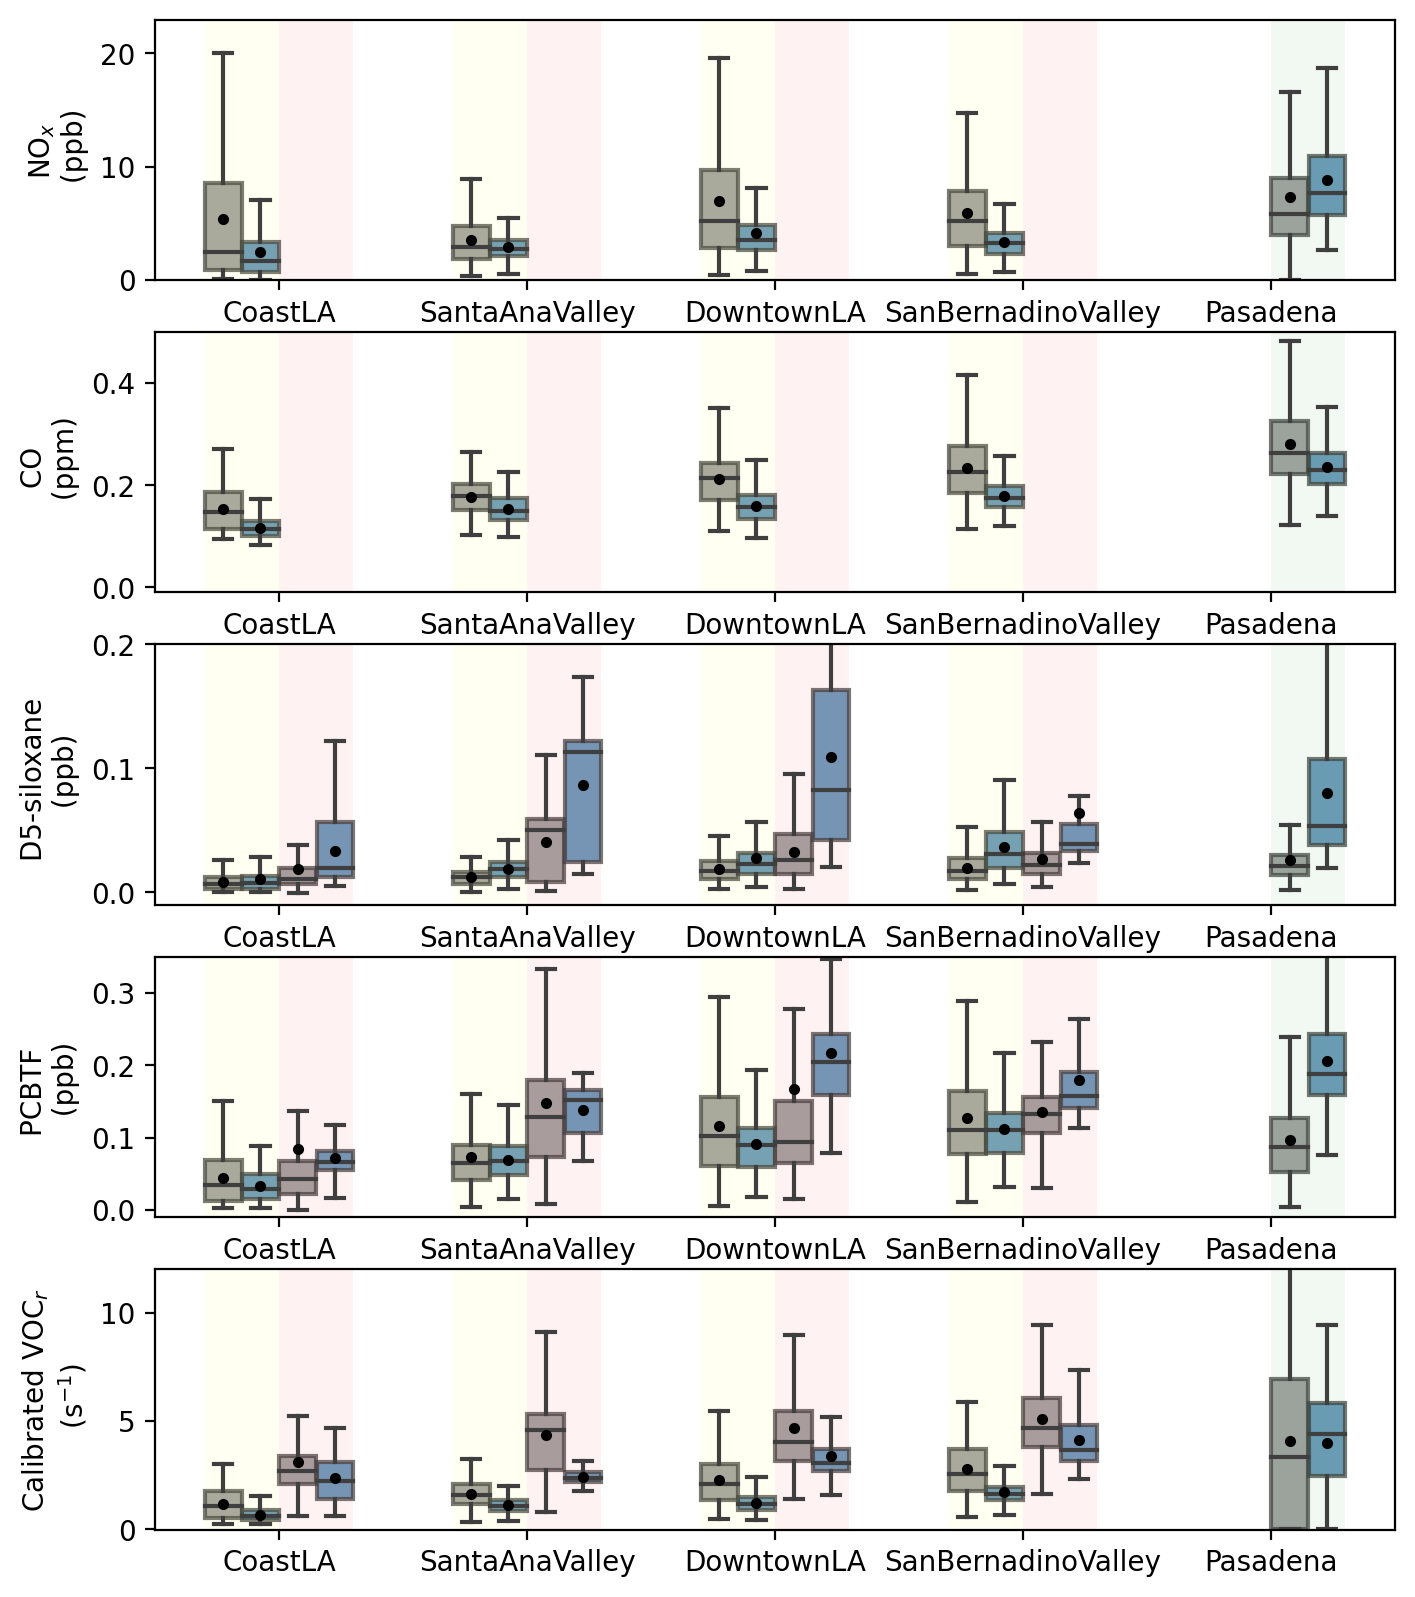

In [14]:
box_colors = ['tab:gray','tab:blue','tab:gray','tab:blue','tab:gray','tab:blue']
labels = ['SUNVEX Mobile', 'RACM2_BERK_SILX_IVOC 12km', 'RACM2_BERK_SILX_IVOC 4km']
fig, axs = plt.subplots(5,1,figsize=(8,10),dpi=200)

ymaxs = [23,0.5,0.2,0.35,12]

for i, i_spc in enumerate([0,1,2,3,4]):
    axs[i].fill_between([-0.3,0],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
    axs[i].fill_between([0,0.3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
    axs[i].fill_between([0.7,1],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
    axs[i].fill_between([1,1.3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
    
    axs[i].fill_between([1.7,2],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
    axs[i].fill_between([2,2.3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
    axs[i].fill_between([2.7,3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
    axs[i].fill_between([3,3.3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
    axs[i].fill_between([4,4.3],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='green',edgecolor='None',alpha=0.05)
    conc_df = concatenate_df(species.loc[i,'col'][0], species.loc[i,'col'][1], species.loc[i,'col'][2], species.loc[i,'col'][3], species.loc[i,'col'][4])

    #plt.figure(figsize=(6,5))
    bplot = sns.boxplot(x='area',y=species.loc[i,'col'][0], hue='data_index', data=conc_df.query('cls_indxs<5'), 
                showfliers = False, width=0.6, palette=box_colors, boxprops=dict(alpha=.7), showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"3"},
                        order = [ 'CoastLA', 'SantaAnaValley', 'DowntownLA', 'SanBernadinoValley', 'Pasadena'], ax=axs[i])

    bplot.get_legend().remove()
    #plt.rcParams["font.family"] = "Times New Roman"
    axs[i].set_ylabel(species.loc[i,'col'][0], fontsize=10)
    axs[i].set_ylim([-0.01,ymaxs[i]])
    axs[i].tick_params(axis='x', labelsize= 10)
    axs[i].set_xlabel('')

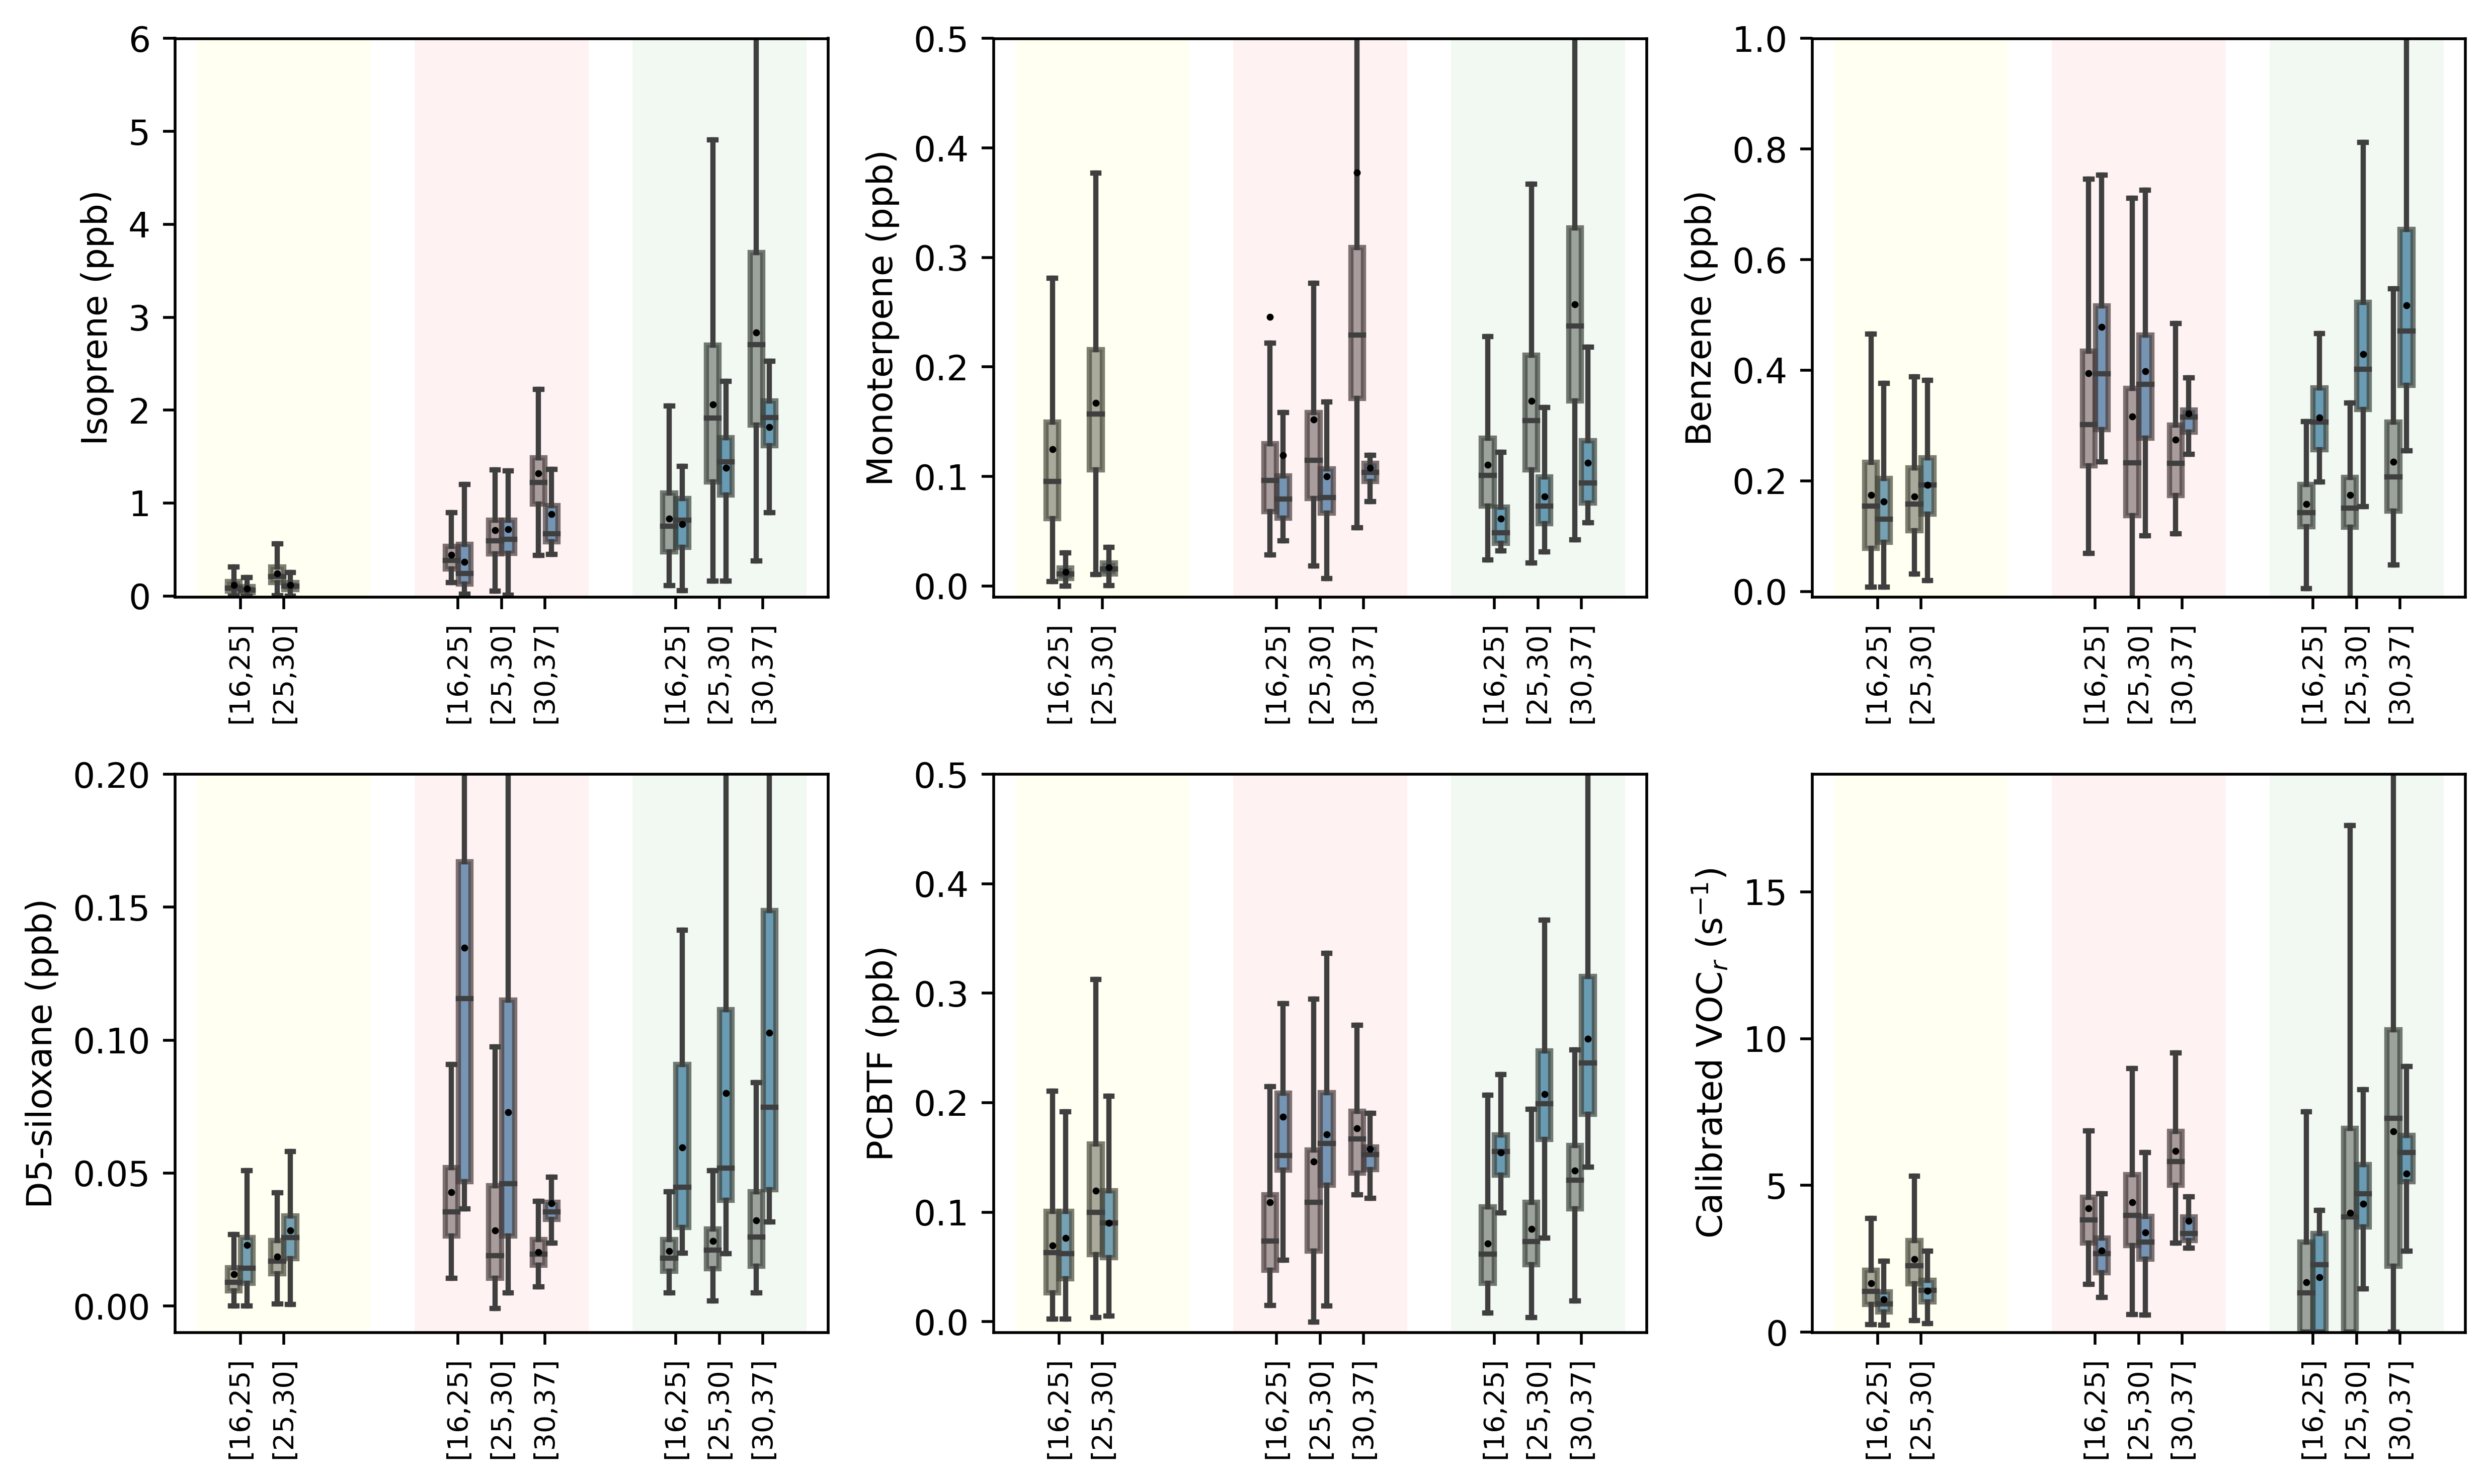

In [16]:
def concatenate_df(pair_model, pair_wrf, airborne_obs, mobile_obs, ground_obs):
    conc_df = pd.DataFrame()

    #combine airborne
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,airborne_obs].values
    this_df.loc[:,'temp_obs'] = df_wrfs[0].loc[:,'temp_obs'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values-5
    this_df.loc[:,'obs']='RECAP'
    this_df.loc[:,'data_index'] = 'obs'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])


    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[0].loc[:,pair_wrf].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[0].loc[:,'temperature_k_x'].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[0].loc[:,'temp_bin_index'].values-5
    this_df.loc[:,'data_index'] = 'wrf'
    this_df.loc[:,'obs']='RECAP'
    this_df.loc[:,'area'] = df_wrfs[0].loc[:,'area'].values
    this_df.loc[:,'cls_indxs'] = df_wrfs[0].loc[:,'cls_indxs'].values
    #this_df.loc[:,'ozone_bias'] = filter_df.loc[:,'ozone_bias'].values
    conc_df = pd.concat([conc_df, this_df])
    
    if (pair_wrf not in ['NOx_model','co']):
        #combine mobile

        this_df = pd.DataFrame()

        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,mobile_obs].values
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_x'].values
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'obs']='SUNVEX Mobile'
        this_df.loc[:,'data_index'] = 'obs'
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])


        this_df = pd.DataFrame()
        this_df.loc[:,pair_model] = df_wrfs[1].loc[:,pair_wrf].values
        this_df.loc[:,'obs']='SUNVEX Mobile'
        this_df.loc[:,'data_index'] = 'wrf'
        this_df.loc[:,'temp_obs'] = df_wrfs[1].loc[:,'AirTemp_C'].values + 273
        this_df.loc[:,'temp_bin_index'] = df_wrfs[1].loc[:,'temp_bin_index'].values
        this_df.loc[:,'temp_wrf'] = df_wrfs[1].loc[:,'temperature_k_y'].values
        this_df.loc[:,'area'] = df_wrfs[1].loc[:,'area'].values
        this_df.loc[:,'cls_indxs'] = df_wrfs[1].loc[:,'cls_indxs'].values
        conc_df = pd.concat([conc_df, this_df])
    
    #combine ground
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,ground_obs].values
    this_df.loc[:,'obs']='SUNVEX Ground'
    this_df.loc[:,'data_index'] = 'obs'
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values+5
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_y'].values
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
   
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_wrf].values
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values+5
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_y'].values
    this_df.loc[:,'obs']='SUNVEX Ground'
    this_df.loc[:,'data_index'] = 'wrf'
    this_df.loc[:,'area'] = 'Pasadena'
    this_df.loc[:,'cls_indxs'] = 4.5
    conc_df = pd.concat([conc_df, this_df])
    return conc_df

box_colors = ['tab:gray','tab:blue','tab:gray','tab:blue','tab:gray','tab:blue']
labels = ['SUNVEX Mobile', 'RACM2_BERK_SILX_IVOC 12km', 'RACM2_BERK_SILX_IVOC 4km']

#from left to right 
#pair_model#airborne_obs, airborne_wrf, mobile_obs, mobile_wrf, ground_obs, ground_wrf
species = pd.DataFrame(columns = ['col'])

spc = ['Isoprene (ppb)','iso','x69_0698776245_C5H9_','isoprene_NOAAPTR_ppbv','isoprene_NOAAPTR_ppbv_all']
species.loc[0,'col'] = spc

spc = ['Monoterpene (ppb)','Monoterpenes_model','x137_1324768066_C10H17_','monoterpenes_NOAAPTR_ppbv','monoterpenes_NOAAPTR_ppbv_all']
species.loc[1,'col'] = spc

spc = ['Benzene (ppb)','ben','x79_0542297363_C6H7_','Benzene_NOAAPTR_ppbv','Benzene_NOAAPTR_ppbv_all']
species.loc[2,'col'] = spc


spc = ['D5-siloxane (ppb)', 'd5silx', 'x371_1012268066_C10H31O5Si5_', 'D5siloxane_NOAAPTR_ppbv', 'D5siloxane_NOAAPTR_ppbv_all']
species.loc[3,'col'] = spc

spc = ['PCBTF (ppb)', 'pcbtf','x181_0026397705_C7H4ClF3H_','PCBTF_NOAAPTR_ppbv','PCBTF_NOAAPTR_ppbv_all']
species.loc[4,'col'] = spc

spc = ['Calibrated VOC$_r$ (s$^{-1}$)', 'calibrated_vocr_model','calibrated_vocr_obs','calibrated_vocr_obs','calibrated_vocr_obs']
species.loc[5,'col'] = spc

fig, axs = plt.subplots(2,3,figsize=(10,6),dpi=500)

ymaxs = [6,0.5,1,0.2,0.50,19]

for i, i_spc in enumerate([0,1,2,3,4,5]):
    i_indx = int(i/3)
    j_indx = i - int(i/3)*3
    axs[i_indx,j_indx].fill_between([-5+5,-1+5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
    axs[i_indx,j_indx].fill_between([0+5,4+5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
    axs[i_indx,j_indx].fill_between([5+5,9+5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='green',edgecolor='None',alpha=0.05)
    
    conc_df = concatenate_df(species.loc[i,'col'][0], species.loc[i,'col'][1], species.loc[i,'col'][2], species.loc[i,'col'][3], species.loc[i,'col'][4])
    conc_df = conc_df.query('cls_indxs<5')
    #plt.figure(figsize=(6,5))
    bplot = sns.boxplot(x='temp_bin_index',y=species.loc[i,'col'][0], hue='data_index', data=conc_df, 
                showfliers = False, order=range(-6,9) ,width=0.6,palette=box_colors, boxprops=dict(alpha=.7), showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"1"}, ax=axs[i_indx,j_indx])

    #ax2 = axs[i].twinx()
    #sns.scatterplot(x='temp_bin_index',y='temp_wrf', data=conc_df.groupby('temp_bin_index').median(),ax=ax2)
    med_temp = conc_df.groupby('temp_bin_index').mean().reset_index()
    #axs[i_indx,j_indx].set_xticks(med_temp['temp_bin_index']+6, (np.rint(med_temp['temp_wrf'])).astype(int), fontsize=10,rotation=90)
    axs[i_indx,j_indx].set_xticks(med_temp['temp_bin_index']+6,['[16,25]','[25,30]','[16,25]','[25,30]','[30,37]','[16,25]','[25,30]','[30,37]'], fontsize=8,rotation=90)
    
    bplot.get_legend().remove()
    #plt.rcParams["font.family"] = "Times New Roman"
    axs[i_indx,j_indx].set_ylabel(species.loc[i,'col'][0], fontsize=10)
    axs[i_indx,j_indx].set_ylim([-0.01,ymaxs[i]])
    #axs[i].tick_params(axis='x', labelsize= 10)
    axs[i_indx,j_indx].set_xlabel('')
 #, order=range(-10,10)   
plt.tight_layout()
    

In [17]:
model_vocr=[col+'_model_vocr' for col in pair_model]
obs_vocr=[col+'_obs_vocr' for col in pair_model]

Text(0, 0.5, 'Calibrated VOC$_r$ (s$^{-1}$)')

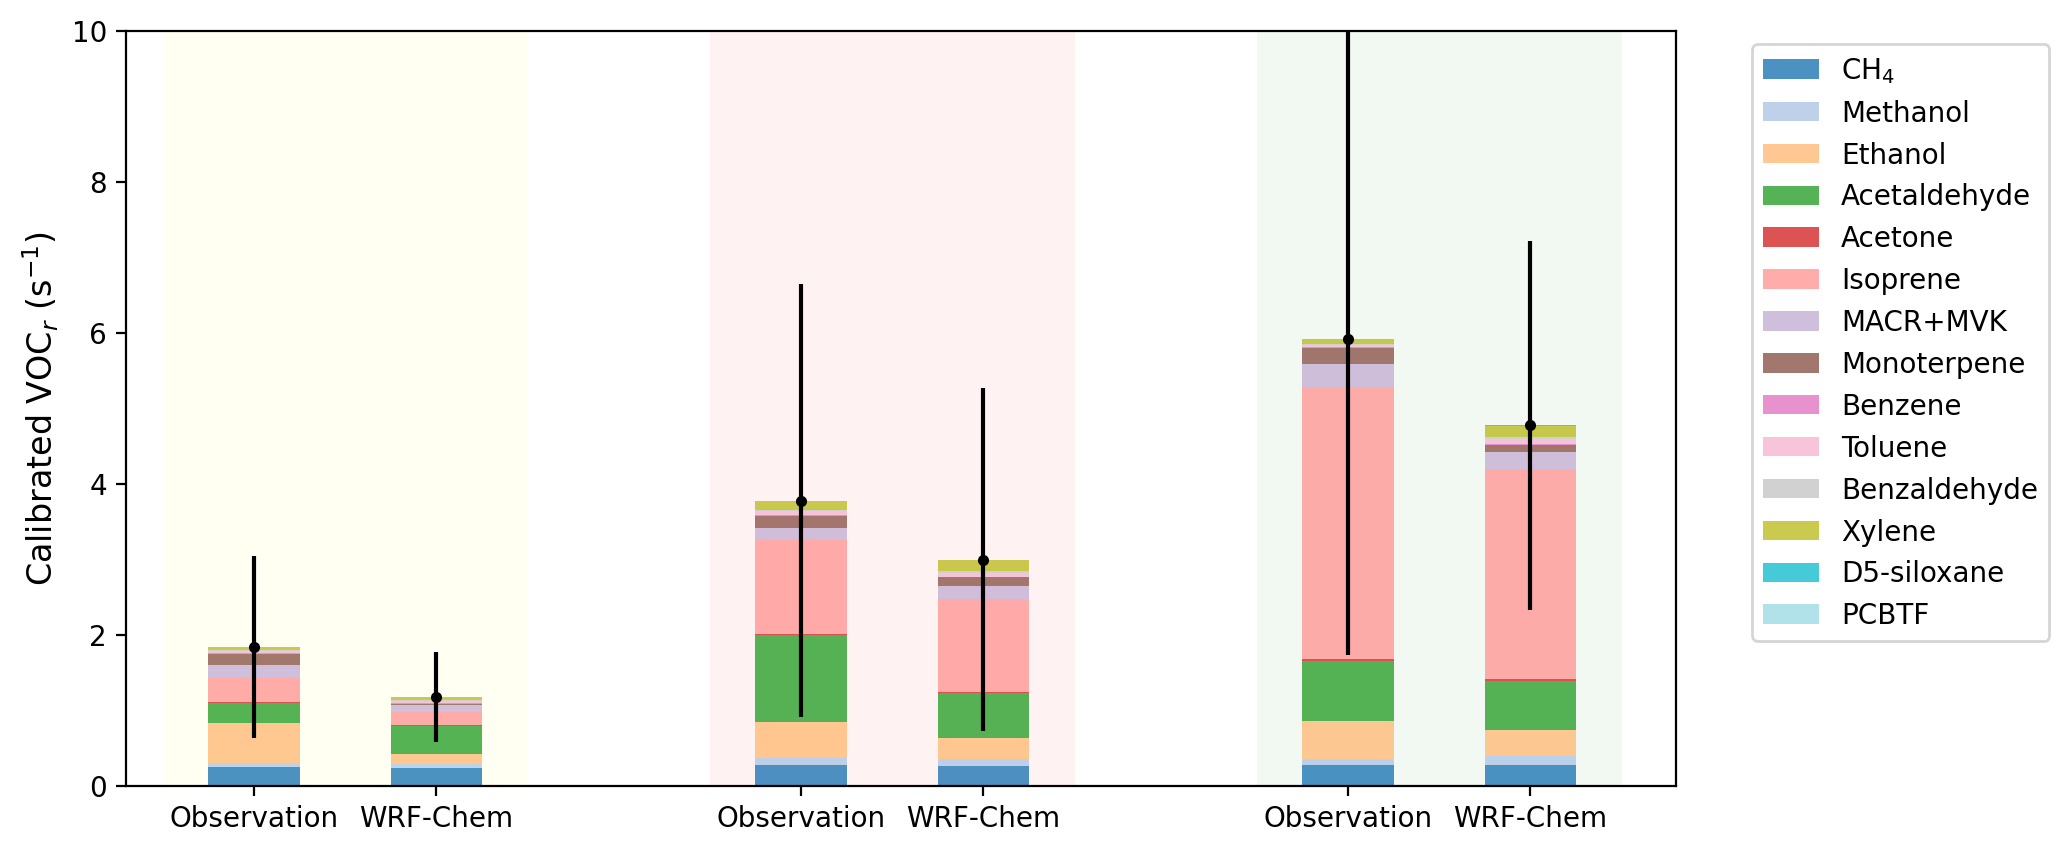

In [18]:
names = ['RECAP','SUNVEX Mobile','SUNVEX Ground']
ymaxs= [2,4,10]
concat_mean_df = pd.DataFrame()
concat_std_df = []
concat_25_df = []
concat_75_df = []
obs_labels = [-2,1,4]
wrf_labels = [-1,2,5]
for i in range(3):
    this_wrf = pd.DataFrame()
    for i_var, this_var in enumerate(pair_model):
        this_wrf.loc[obs_labels[i],this_var] = np.nanmedian(df_vocrs[i].loc[:,this_var+'_obs_vocr'])
        this_wrf.loc[wrf_labels[i],this_var] = np.nanmedian(df_vocrs[i].loc[:,this_var+'_model_vocr'])
        this_wrf.loc[wrf_labels[i]+1,this_var] = np.nan
    concat_mean_df = pd.concat([concat_mean_df,this_wrf])
    concat_std_df.append(np.nanstd(df_vocrs[i].loc[:,obs_vocr].sum(axis=1)))
    concat_std_df.append(np.nanstd(df_vocrs[i].loc[:,model_vocr].sum(axis=1)))
    
    concat_25_df.append(np.nanquantile(df_vocrs[i].loc[:,obs_vocr].sum(axis=1),0.25))
    concat_25_df.append(np.nanquantile(df_vocrs[i].loc[:,model_vocr].sum(axis=1),0.25))
    
    concat_75_df.append(np.nanquantile(df_vocrs[i].loc[:,obs_vocr].sum(axis=1),0.75))
    concat_75_df.append(np.nanquantile(df_vocrs[i].loc[:,model_vocr].sum(axis=1),0.75))
    
mean_df = concat_mean_df.sum(axis=1)   
fig, axs = plt.subplots(1,1,figsize=(10,5),dpi=200)
plt.fill_between([-0.5,1.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='yellow',edgecolor='None',alpha=0.05)
plt.fill_between([2.5,4.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='red',edgecolor='None',alpha=0.05)
    
plt.fill_between([5.5,7.5],[-0.01,-0.01],[ymaxs[i],ymaxs[i]], facecolor='green',edgecolor='None',alpha=0.05)
    
concat_mean_df.plot(kind='bar', stacked=True,ax=axs, edgecolor='none',colormap='tab20',alpha=0.8, rot=0)
plt.errorbar(np.array([-2,-1,1,2,4,5])+2, mean_df[mean_df>0].values, yerr=concat_std_df, fmt='.',color='k')

axs.set_xticks(np.array([-2,-1,1,2,4,5])+2, ['Observation','WRF-Chem']*3, fontsize=10)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlim([-0.7,7.8])
plt.ylim([0,10])
plt.ylabel('Calibrated VOC$_r$ (s$^{-1}$)',fontsize=12)

In [19]:
df_sum = concat_mean_df.sum(axis=1)
print((df_sum[-1]-df_sum[-2])/df_sum[-2])
print((df_sum[2]-df_sum[1])/df_sum[1])
print((df_sum[5]-df_sum[4])/df_sum[4])

-0.3623254404272574
-0.2062752219827347
-0.1927118777758152


In [20]:
(concat_mean_df.loc[-1,:] - concat_mean_df.loc[-2,:])/concat_mean_df.loc[-2,:]

CH$_4$         -0.043028
Methanol        0.005949
Ethanol        -0.753082
Acetaldehyde    0.463759
Acetone        -0.329867
Isoprene       -0.459461
MACR+MVK       -0.481527
Monoterpene    -0.894898
Benzene         0.059862
Toluene        -0.049520
Benzaldehyde    0.054859
Xylene         -0.091937
D5-siloxane     0.594478
PCBTF          -0.053463
dtype: float64

-0.3851393599342333
0.011913164523517514
0.06645942267790017
0.08594741010548243
-0.9999999999999994


Text(0.5, 0, '')

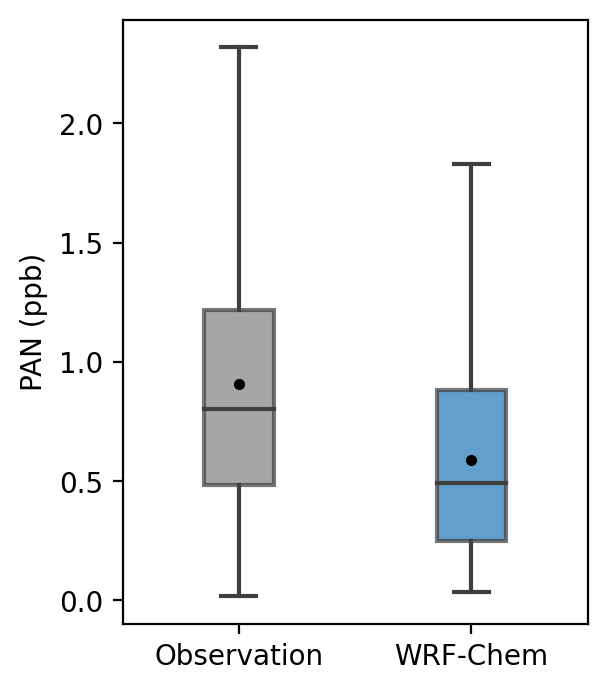

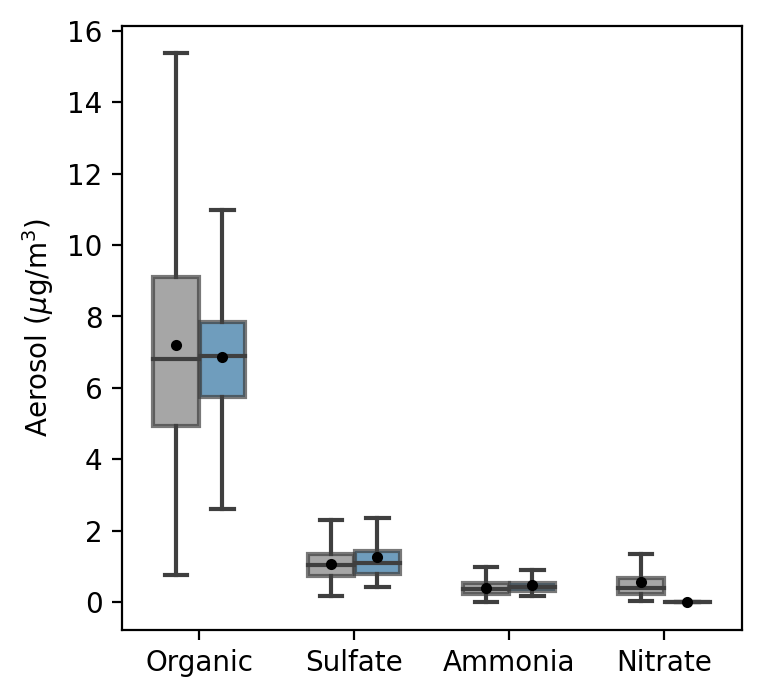

In [22]:
#ground measurements only
def concatenate_ground_df(pair_obs, pair_wrf, pair_model):
    conc_df = pd.DataFrame()
    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_obs].values
    this_df.loc[:,'tag'] = 'Observation'
    this_df.loc[:,'data_index'] = 0
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    conc_df = pd.concat([conc_df, this_df])

    this_df = pd.DataFrame()
    this_df.loc[:,pair_model] = df_wrfs[2].loc[:,pair_wrf].values
    this_df.loc[:,'tag'] = 'WRF-Chem'
    this_df.loc[:,'data_index'] = 2
    this_df.loc[:,'temp_bin_index'] = df_wrfs[2].loc[:,'temp_bin_index'].values
    this_df.loc[:,'temp_wrf'] = df_wrfs[2].loc[:,'temperature_k_x'].values
    conc_df = pd.concat([conc_df, this_df])
    
    conc_df.dropna(subset=pair_model)
    return conc_df

species = pd.DataFrame(columns = ['col'])

spc = ['Organic aerosol ($\mu$g/m$^3$)','AerComp_OrganicAerosol_PM1','organic_model']
species.loc[0,'col'] = spc

spc = ['Sulfate ($\mu$g/m$^3$)','AerComp_Sulfate_PM1','so4_model']
species.loc[1,'col'] = spc

spc = ['Ammonia ($\mu$g/m$^3$)','AerComp_Ammonium_PM1','nh4_model']
species.loc[2,'col'] = spc

spc = ['Nitrate ($\mu$g/m$^3$)','AerComp_Nitrate_PM1','no3_model']
species.loc[3,'col'] = spc

spc = ['PAN (ppb)','PAN_NOAACIMS_v1','pan']
species.loc[4,'col'] = spc


#PAN
fig, axs = plt.subplots(1,1,figsize=(3,4),dpi=200)
pair_obs = species.loc[4,'col'][1]
pair_wrf = species.loc[4,'col'][2]
pair_model = species.loc[4,'col'][0]
conc_df = concatenate_ground_df(pair_obs, pair_wrf, pair_model)
this_df = conc_df.groupby('tag').median()
diff = (this_df.loc['WRF-Chem'][pair_model]-this_df.loc['Observation'][pair_model])/this_df.loc['Observation'][pair_model]
print(diff)
bplot = sns.boxplot(x='tag',y=pair_model, data=conc_df,showmeans=True,
                    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"3"},
                    showfliers = False, width=0.3,ax=axs, boxprops=dict(alpha=.7))
axs.set_xlabel('')
axs.tick_params(axis='x', labelsize= 10)
box_colors = ['gray','tab:blue']
if len(bplot.patches) == 2:
    for i in range(len(bplot.patches)):
        mybox = bplot.patches[i]
        # Change the appearance of that box
        mybox.set_facecolor(box_colors[i])
        #mybox.set_alpha(0.6)

#SOA
conc_dfs = pd.DataFrame()

for i, i_spc in enumerate(range(4)):
    
    pair_obs = species.loc[i,'col'][1]
    pair_wrf = species.loc[i,'col'][2]
    pair_model = species.loc[i,'col'][0]

    conc_df = concatenate_ground_df(pair_obs, pair_wrf, pair_model)
    this_df = conc_df.groupby('tag').median()
    diff = (this_df.loc['WRF-Chem'][pair_model]-this_df.loc['Observation'][pair_model])/this_df.loc['Observation'][pair_model]
    print(diff)
    conc_df = conc_df.rename(columns={pair_model:'Value'})
    conc_df.loc[:,'Species'] = pair_model.split(' ')[0]
    conc_dfs = pd.concat([conc_dfs, conc_df])
    
fig, axs = plt.subplots(1,1,figsize=(4,4),dpi=200)
bplot = sns.boxplot(x='Species',y='Value', hue='data_index', data=conc_dfs, showmeans=True,
                showfliers = False, width=0.6, meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black","markersize":"3"},
                    palette=box_colors, boxprops=dict(alpha=.7),ax=axs)

bplot.get_legend().remove()
axs.set_xlim([-0.5,3.5])
axs.set_ylabel('Aerosol ($\mu$g/m$^3$)', fontsize=10)
axs.tick_params(axis='x', labelsize= 10)
axs.set_xlabel('')
